In [6]:
# ==========================
# CRISP-DM: Business Understanding / Setup
# Project bootstrap: imports, device check, reproducibility, dataset download
# ==========================

# Standard libs
import os, sys, random, json, shutil
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

# Repro & numerics
import numpy as np

# Deep learning
import torch

# Vision utils (we'll use these later; ok to import now)
import torchvision
from torchvision import transforms

# Visualization (used later)
import matplotlib.pyplot as plt

# Dataset download via KaggleHub (as you provided)
import kagglehub

# --------------------------
# 1) Reproducibility helpers
# --------------------------
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # Make some ops deterministic when possible (may slightly reduce speed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True  # Good for performance when input sizes are constant

set_seed(42)

# --------------------------
# 2) Device discovery
# --------------------------
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    # Apple Silicon (Metal) support
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

DEVICE = get_device()

def env_summary():
    info = {
        "python": sys.version.split()[0],
        "torch_version": torch.__version__,
        "torchvision_version": torchvision.__version__,
        "device": str(DEVICE),
        "cuda_available": torch.cuda.is_available(),
        "num_cpu_threads": os.cpu_count(),
    }
    print(json.dumps(info, indent=2))

print("== Environment Summary ==")
env_summary()

# --------------------------
# 3) Project directories
# --------------------------
ROOT = Path(".").resolve()
ARTIFACTS_DIR = ROOT / "artifacts"
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)  # for checkpoints, logs, etc.
print(f"Artifacts will be saved to: {ARTIFACTS_DIR}")

# --------------------------
# 4) Download dataset (KaggleHub)
#    Dataset: alxmamaev/flowers-recognition
#    Structure: <download_path>/flowers/<class_name>/*.jpg
# --------------------------
print("Downloading dataset via kagglehub (first run may take a bit depending on your connection)...")
ds_path = kagglehub.dataset_download("alxmamaev/flowers-recognition")
print("Path to dataset files:", ds_path)

# The actual images are inside a 'flowers' subfolder in this dataset
DATASET_DIR = Path(ds_path) / "flowers"
if not DATASET_DIR.exists():
    # Fallback: if structure changes, just use the root as-is
    DATASET_DIR = Path(ds_path)

print(f"Resolved dataset directory: {DATASET_DIR}")

# Quick sanity check of class folders
if DATASET_DIR.exists():
    class_dirs = [p.name for p in DATASET_DIR.iterdir() if p.is_dir()]
    print(f"Found class folders: {sorted(class_dirs)}")
    # Count a few samples per class (lightweight)
    counts = {c: len(list((DATASET_DIR / c).glob("*"))) for c in class_dirs}
    print("Sample counts (first few):", dict(list(counts.items())[:10]))
else:
    raise FileNotFoundError("Dataset directory not found. Please verify the KaggleHub path.")

# --------------------------
# 5) Global configuration (tweak later as needed)
# --------------------------
from dataclasses import dataclass

@dataclass
class Config:
    dataset_dir: Path = DATASET_DIR
    artifacts_dir: Path = ARTIFACTS_DIR
    image_size: int = 224                # smaller => faster & lighter
    batch_size: int = 16                 # start small for CPU, we can tune later
    num_workers: int = max(1, (os.cpu_count() or 2) // 2)  # conservative for notebooks
    model_name: str = "efficientnet_b0"  # or "mobilenet_v3_small" (even lighter)
    learning_rate: float = 3e-4
    weight_decay: float = 1e-4
    label_smoothing: float = 0.1
    epochs: int = 10                     # placeholder; early stopping will guard overfit
    freeze_backbone_epochs: int = 2      # warmup with frozen backbone
    mixed_precision: bool = True         # autocast if GPU/MPS is available

CFG = Config()
print("Config:", CFG)

# Save config snapshot for reproducibility
with open(CFG.artifacts_dir / "config.json", "w") as f:
    json.dump({k: str(v) if isinstance(v, Path) else v for k, v in CFG.__dict__.items()}, f, indent=2)
print(f"Saved config to {CFG.artifacts_dir / 'config.json'}")


== Environment Summary ==
{
  "python": "3.12.11",
  "torch_version": "2.8.0+cu126",
  "torchvision_version": "0.23.0+cu126",
  "device": "cpu",
  "cuda_available": false,
  "num_cpu_threads": 2
}
Artifacts will be saved to: /content/artifacts
Using Colab cache for faster access to the 'flowers-recognition' dataset.
Path to dataset files: /kaggle/input/flowers-recognition
Resolved dataset directory: /kaggle/input/flowers-recognition/flowers
Found class folders: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Sample counts (first few): {'dandelion': 1052, 'daisy': 764, 'sunflower': 733, 'tulip': 984, 'rose': 784}
Config: Config(dataset_dir=PosixPath('/kaggle/input/flowers-recognition/flowers'), artifacts_dir=PosixPath('/content/artifacts'), image_size=224, batch_size=16, num_workers=1, model_name='efficientnet_b0', learning_rate=0.0003, weight_decay=0.0001, label_smoothing=0.1, epochs=10, freeze_backbone_epochs=2, mixed_precision=True)
Saved config to /content/artifacts/config.json

Scanning dataset and building manifest...
Classes (5): ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Total images found: 4317
Saved manifest to /content/artifacts/manifest.csv

Creating stratified train/val/test splits (70/15/15)...
Saved splits:
  /content/artifacts/train.csv
  /content/artifacts/val.csv
  /content/artifacts/test.csv

== Overall class counts ==
label
daisy         764
dandelion    1052
rose          784
sunflower     733
tulip         984

Class proportions:
label
daisy        0.177
dandelion    0.244
rose         0.182
sunflower    0.170
tulip        0.228

== Train class counts ==
label
daisy        535
dandelion    736
rose         549
sunflower    513
tulip        688

Class proportions:
label
daisy        0.177
dandelion    0.244
rose         0.182
sunflower    0.170
tulip        0.228

== Val class counts ==
label
daisy        114
dandelion    158
rose         118
sunflower    110
tulip        148

Class proportions:
label
daisy        0.176
dandelion    

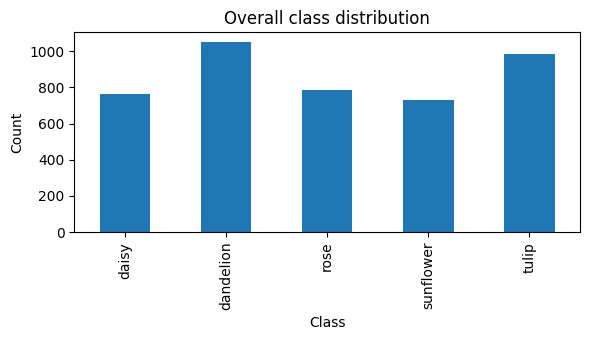


Computing lightweight image dimension stats (sampled)...
Image stats (sampled):
{
  "width": {
    "count": 500,
    "min": 134,
    "p05": 159.0,
    "median": 320.0,
    "mean": 340.376,
    "p95": 500.0,
    "max": 500
  },
  "height": {
    "count": 500,
    "min": 80,
    "p05": 159.0,
    "median": 240.0,
    "mean": 255.262,
    "p95": 335.0,
    "max": 425
  },
  "corrupted_or_unreadable": 0,
  "sampled_images": 4317
}
Saved image stats to /content/artifacts/image_stats.json

Showing a small grid of training samples (may take a moment on CPU)...


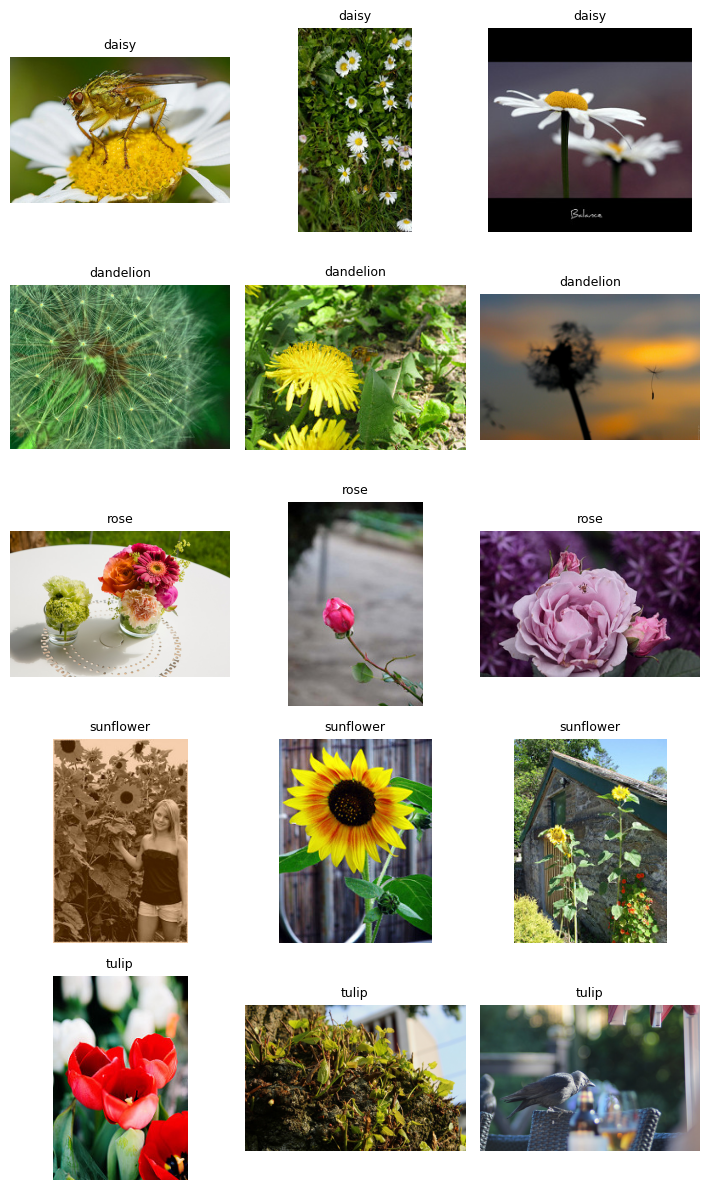

In [7]:
# ==========================
# CRISP-DM: Data Understanding
# Build manifest, stratified splits, light EDA, and sample visualization
# ==========================
from pathlib import Path
import random, json
from collections import Counter, defaultdict

import pandas as pd
import numpy as np
from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# ---------- Helpers ----------
def list_images_by_class(root: Path, exts={".jpg", ".jpeg", ".png", ".bmp"}):
    """Scan <root>/<class_name>/* and return list of (path, class_name)."""
    records = []
    classes = []
    for d in sorted(p for p in root.iterdir() if p.is_dir()):
        cls = d.name
        classes.append(cls)
        for p in d.iterdir():
            if p.is_file() and p.suffix.lower() in exts:
                records.append((str(p), cls))
    return records, sorted(classes)

def make_manifest(dataset_dir: Path) -> pd.DataFrame:
    recs, classes = list_images_by_class(dataset_dir)
    if not recs:
        raise RuntimeError(f"No images found under {dataset_dir}.")
    label_to_idx = {c: i for i, c in enumerate(classes)}
    df = pd.DataFrame(recs, columns=["path", "label"])
    df["label_idx"] = df["label"].map(label_to_idx)
    return df, classes, label_to_idx

def stratified_splits(df: pd.DataFrame, train=0.70, val=0.15, test=0.15, seed=42):
    assert abs(train + val + test - 1.0) < 1e-6, "Splits must sum to 1.0"
    # First split train vs temp
    df_train, df_temp = train_test_split(
        df, test_size=(1.0 - train), stratify=df["label_idx"], random_state=seed
    )
    # Split temp into val and test
    rel_val = val / (val + test)
    df_val, df_test = train_test_split(
        df_temp, test_size=(1.0 - rel_val), stratify=df_temp["label_idx"], random_state=seed
    )
    return df_train.reset_index(drop=True), df_val.reset_index(drop=True), df_test.reset_index(drop=True)

def summarize_counts(df: pd.DataFrame, title: str):
    counts = df["label"].value_counts().sort_index()
    print(f"\n== {title} ==")
    print(counts.to_string())
    print("\nClass proportions:")
    print((counts / counts.sum()).round(3).to_string())

def robust_image_open(path: str):
    """Open image safely and return PIL.Image or None if corrupted."""
    try:
        img = Image.open(path).convert("RGB")
        return img
    except (UnidentifiedImageError, OSError):
        return None

def sample_image_stats(df: pd.DataFrame, max_per_class=100, seed=42):
    """Compute lightweight width/height stats on a small sample (CPU friendly)."""
    rng = np.random.default_rng(seed)
    sampled = []
    for cls, sub in df.groupby("label"):
        use = min(max_per_class, len(sub))
        sampled.append(sub.sample(n=use, random_state=seed))
    sampled_df = pd.concat(sampled, ignore_index=True)
    widths, heights, bad = [], [], 0
    for p in sampled_df["path"]:
        img = robust_image_open(p)
        if img is None:
            bad += 1
            continue
        w, h = img.size  # PIL gives (W, H)
        widths.append(w); heights.append(h)
    def stats(arr):
        arr = np.array(arr)
        if arr.size == 0:
            return {}
        return {
            "count": int(arr.size),
            "min": int(arr.min()),
            "p05": float(np.percentile(arr, 5)),
            "median": float(np.median(arr)),
            "mean": float(arr.mean()),
            "p95": float(np.percentile(arr, 95)),
            "max": int(arr.max()),
        }
    return {
        "width": stats(widths),
        "height": stats(heights),
        "corrupted_or_unreadable": int(bad),
        "sampled_images": int(sum(len(s) for _, s in df.groupby("label")) if df is not None else 0)
    }

def plot_class_distribution(df: pd.DataFrame, title="Class distribution"):
    counts = df["label"].value_counts().sort_index()
    plt.figure(figsize=(6, 3.5))
    counts.plot(kind="bar")
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

def show_sample_grid(df: pd.DataFrame, n_per_class=3, seed=42):
    """Show a small grid of images per class from df."""
    rng = random.Random(seed)
    groups = df.groupby("label")
    samples = []
    for cls, sub in groups:
        pick = sub.sample(n=min(n_per_class, len(sub)), random_state=seed)
        for _, row in pick.iterrows():
            samples.append((row["path"], cls))
    if not samples:
        print("No samples to display.")
        return
    cols = n_per_class
    classes = sorted(df["label"].unique())
    rows = len(classes)
    plt.figure(figsize=(cols * 2.4, rows * 2.4))
    i = 1
    for cls in classes:
        sub = [s for s in samples if s[1] == cls]
        for j, (p, lbl) in enumerate(sub):
            img = robust_image_open(p)
            if img is None:  # skip corrupted
                continue
            plt.subplot(rows, cols, i)
            plt.imshow(img)
            plt.axis("off")
            plt.title(lbl, fontsize=9)
            i += 1
    plt.tight_layout()
    plt.show()

# ---------- Execute Data Understanding pipeline ----------
print("Scanning dataset and building manifest...")
df_all, classes, label_to_idx = make_manifest(CFG.dataset_dir)
print(f"Classes ({len(classes)}): {classes}")
print(f"Total images found: {len(df_all)}")

# Save manifest for reproducibility
manifest_path = CFG.artifacts_dir / "manifest.csv"
df_all.to_csv(manifest_path, index=False)
print(f"Saved manifest to {manifest_path}")

# Stratified splits
print("\nCreating stratified train/val/test splits (70/15/15)...")
train_df, val_df, test_df = stratified_splits(df_all, train=0.70, val=0.15, test=0.15, seed=42)

# Save split CSVs
train_csv = CFG.artifacts_dir / "train.csv"
val_csv   = CFG.artifacts_dir / "val.csv"
test_csv  = CFG.artifacts_dir / "test.csv"
train_df.to_csv(train_csv, index=False)
val_df.to_csv(val_csv, index=False)
test_df.to_csv(test_csv, index=False)
print(f"Saved splits:\n  {train_csv}\n  {val_csv}\n  {test_csv}")

# Summaries
summarize_counts(df_all, "Overall class counts")
summarize_counts(train_df, "Train class counts")
summarize_counts(val_df, "Val class counts")
summarize_counts(test_df, "Test class counts")

# Plot distribution (overall)
plot_class_distribution(df_all, title="Overall class distribution")

# Lightweight image dimension stats (safe sample, ~<=100 per class)
print("\nComputing lightweight image dimension stats (sampled)...")
img_stats = sample_image_stats(df_all, max_per_class=100, seed=42)
stats_path = CFG.artifacts_dir / "image_stats.json"
with open(stats_path, "w") as f:
    json.dump(img_stats, f, indent=2)
print("Image stats (sampled):")
print(json.dumps(img_stats, indent=2))
print(f"Saved image stats to {stats_path}")

# Visual sanity-check: a few training images per class
print("\nShowing a small grid of training samples (may take a moment on CPU)...")
show_sample_grid(train_df, n_per_class=3, seed=42)


In [8]:
# ==========================
# CRISP-DM: Data Preparation
# Transforms, Dataset, Sampler, and DataLoaders
# ==========================
from dataclasses import asdict
from pathlib import Path
import json, random
from typing import Tuple, Dict, Optional

import pandas as pd
import numpy as np
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms

# Reuse CFG, DEVICE from earlier chunks
assert 'CFG' in globals(), "Config (CFG) not found. Please run Chunk 1 first."
assert (CFG.artifacts_dir / "train.csv").exists(), "Missing train/val/test CSVs. Please run Chunk 2."

# --------------------------
# 1) Transforms & Augmentations
# --------------------------
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

def build_transforms(image_size: int = 224, normalize: str = "imagenet"):
    """
    Returns torchvision transforms for train/eval.
    Designed to be light but effective for natural images on small compute.
    """
    if normalize == "imagenet":
        norm_mean, norm_std = IMAGENET_MEAN, IMAGENET_STD
    else:
        # Placeholder for custom stats; ImageNet is usually best for transfer learning speed.
        norm_mean, norm_std = IMAGENET_MEAN, IMAGENET_STD

    train_tfms = transforms.Compose([
        transforms.RandomResizedCrop(image_size, scale=(0.7, 1.0), ratio=(0.75, 1.33)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.10, hue=0.02),
        transforms.RandomRotation(degrees=10),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std),
    ])

    eval_tfms = transforms.Compose([
        transforms.Resize(int(image_size * 1.15)),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std),
    ])
    return train_tfms, eval_tfms

# --------------------------
# 2) CSV-driven Dataset
# --------------------------
class FlowerCsvDataset(Dataset):
    """
    Lightweight dataset that reads image paths/labels from a CSV.
    Expects columns: ['path', 'label', 'label_idx'] as created in Chunk 2.
    """
    def __init__(self, csv_path: Path, transform=None):
        self.df = pd.read_csv(csv_path)
        # minimal validation
        for col in ("path", "label", "label_idx"):
            if col not in self.df.columns:
                raise ValueError(f"CSV at {csv_path} missing column: {col}")
        self.paths = self.df["path"].tolist()
        self.targets = self.df["label_idx"].astype(int).tolist()
        self.labels = self.df["label"].tolist()
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx: int):
        path = self.paths[idx]
        target = self.targets[idx]
        # Robust load (RGB)
        with Image.open(path) as img:
            img = img.convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        return img, target

# --------------------------
# 3) Reproducible workers & class weights
# --------------------------
def seed_worker(worker_id):
    # Ensures dataloader workers are deterministically seeded
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

def compute_class_weights(train_csv: Path) -> Dict[int, float]:
    """
    Inverse-frequency weights per class (for optional WeightedRandomSampler).
    """
    df = pd.read_csv(train_csv)
    counts = df["label_idx"].value_counts().sort_index()
    total = counts.sum()
    # Classic inverse frequency; scale so mean ~1.0
    inv = total / (len(counts) * counts)
    weights = {int(k): float(v) for k, v in inv.items()}
    return weights

def build_weighted_sampler(train_df: pd.DataFrame, class_weights: Dict[int, float]) -> WeightedRandomSampler:
    """
    Create a per-sample weight vector mapped from class_weights.
    """
    sample_weights = [class_weights[int(c)] for c in train_df["label_idx"].tolist()]
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
    return sampler

# --------------------------
# 4) DataLoaders factory
# --------------------------
def build_dataloaders(cfg,
                      use_weighted_sampler: bool = False,
                      persistent_workers: Optional[bool] = None):
    """
    Returns train/val/test DataLoaders with sensible defaults.
    """
    train_csv = cfg.artifacts_dir / "train.csv"
    val_csv   = cfg.artifacts_dir / "val.csv"
    test_csv  = cfg.artifacts_dir / "test.csv"

    train_tfms, eval_tfms = build_transforms(cfg.image_size)

    train_ds = FlowerCsvDataset(train_csv, transform=train_tfms)
    val_ds   = FlowerCsvDataset(val_csv, transform=eval_tfms)
    test_ds  = FlowerCsvDataset(test_csv, transform=eval_tfms)

    # Sampler (optional, helpful for imbalance)
    sampler = None
    if use_weighted_sampler:
        class_w = compute_class_weights(train_csv)
        # Persist for reference
        with open(cfg.artifacts_dir / "class_weights.json", "w") as f:
            json.dump({str(k): v for k, v in class_w.items()}, f, indent=2)
        df_train = pd.read_csv(train_csv)
        sampler = build_weighted_sampler(df_train, class_w)

    # pin_memory helps only with CUDA generally
    pin_mem = (DEVICE.type == "cuda")
    if persistent_workers is None:
        persistent_workers = (cfg.num_workers > 0)

    # Dataloaders
    generator = torch.Generator()
    generator.manual_seed(42)

    train_loader = DataLoader(
        train_ds,
        batch_size=cfg.batch_size,
        shuffle=(sampler is None),
        sampler=sampler,
        num_workers=cfg.num_workers,
        pin_memory=pin_mem,
        drop_last=False,
        worker_init_fn=seed_worker,
        persistent_workers=persistent_workers,
        prefetch_factor=2 if cfg.num_workers > 0 else None,
        generator=generator,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=max(1, cfg.batch_size // 2),  # eval can be smaller to reduce memory
        shuffle=False,
        num_workers=cfg.num_workers,
        pin_memory=pin_mem,
        drop_last=False,
        worker_init_fn=seed_worker,
        persistent_workers=persistent_workers,
        prefetch_factor=2 if cfg.num_workers > 0 else None,
        generator=generator,
    )

    test_loader = DataLoader(
        test_ds,
        batch_size=max(1, cfg.batch_size // 2),
        shuffle=False,
        num_workers=cfg.num_workers,
        pin_memory=pin_mem,
        drop_last=False,
        worker_init_fn=seed_worker,
        persistent_workers=persistent_workers,
        prefetch_factor=2 if cfg.num_workers > 0 else None,
        generator=generator,
    )

    meta = {
        "num_classes": int(pd.read_csv(train_csv)["label_idx"].nunique()),
        "class_names": sorted(pd.read_csv(cfg.artifacts_dir / "manifest.csv")["label"].unique().tolist()),
    }
    with open(cfg.artifacts_dir / "data_meta.json", "w") as f:
        json.dump(meta, f, indent=2)
    print("Data meta:", meta)

    return train_loader, val_loader, test_loader

# --------------------------
# 5) (Optional) quick preview of an augmented batch
# --------------------------
def show_augmented_batch(train_loader, max_images=12):
    import matplotlib.pyplot as plt
    batch = next(iter(train_loader))
    imgs, targets = batch
    n = min(max_images, imgs.size(0))
    # Unnormalize for display
    mean = torch.tensor(IMAGENET_MEAN).view(3,1,1)
    std  = torch.tensor(IMAGENET_STD).view(3,1,1)

    plt.figure(figsize=(n * 1.7, 1.7 * 2))
    for i in range(n):
        img = imgs[i].cpu() * std + mean
        img = img.clamp(0,1).permute(1,2,0).numpy()
        plt.subplot(2, (n+1)//2, i+1)
        plt.imshow(img)
        plt.title(f"y={int(targets[i])}", fontsize=9)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# --------------------------
# 6) Run the prep pipeline
# --------------------------
print("Building dataloaders...")
train_loader, val_loader, test_loader = build_dataloaders(CFG, use_weighted_sampler=False)
print("Train/Val/Test sizes:",
      len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset))

# Optional: uncomment to visualize augmentations (can be skipped on tight CPU)
# show_augmented_batch(train_loader, max_images=8)


Building dataloaders...
Data meta: {'num_classes': 5, 'class_names': ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']}
Train/Val/Test sizes: 3021 648 648


In [9]:
# ==========================
# CRISP-DM: Modeling
# Transfer learning with EfficientNet-B0 (default) or MobileNetV3-Small
# Features: freeze-then-finetune, label smoothing, AdamW, OneCycleLR, early stopping, AMP on CUDA
# ==========================
import contextlib, json, math, time
from dataclasses import asdict
from pathlib import Path
from typing import Tuple, Dict, Any

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torchvision import models

# Reuse globals from previous chunks
assert 'CFG' in globals(), "Missing CFG. Run Chunk 1."
assert 'train_loader' in globals() and 'val_loader' in globals(), "Build dataloaders in Chunk 3 first."

# --------------------------
# 0) Data meta (classes)
# --------------------------
with open(CFG.artifacts_dir / "data_meta.json") as f:
    DATA_META = json.load(f)
NUM_CLASSES = int(DATA_META["num_classes"])
CLASS_NAMES = DATA_META["class_names"]

# --------------------------
# 1) Model builder
# --------------------------
def _get_weights_enum(model_name: str):
    """
    Handle torchvision weights enum across versions.
    Falls back to .DEFAULT if available.
    """
    if model_name == "efficientnet_b0":
        try:
            return models.EfficientNet_B0_Weights.IMAGENET1K_V1
        except AttributeError:
            return models.EfficientNet_B0_Weights.DEFAULT
    elif model_name == "mobilenet_v3_small":
        try:
            return models.MobileNet_V3_Small_Weights.IMAGENET1K_V1
        except AttributeError:
            return models.MobileNet_V3_Small_Weights.DEFAULT
    else:
        raise ValueError(f"Unsupported model_name: {model_name}")

def build_model(model_name: str, num_classes: int) -> nn.Module:
    weights = _get_weights_enum(model_name)
    if model_name == "efficientnet_b0":
        net = models.efficientnet_b0(weights=weights)
        in_features = net.classifier[1].in_features
        # Keep the default dropout in classifier; just swap final linear
        net.classifier[1] = nn.Linear(in_features, num_classes)
    elif model_name == "mobilenet_v3_small":
        net = models.mobilenet_v3_small(weights=weights)
        in_features = net.classifier[-1].in_features
        # MobileNetV3 classifier already has Dropout; replace last Linear
        net.classifier[-1] = nn.Linear(in_features, num_classes)
    else:
        raise ValueError(f"Unsupported model_name: {model_name}")
    return net

def split_param_groups(model: nn.Module, head_key: str = "classifier"):
    """
    Return (backbone_params, head_params) by module name prefix.
    Works for both EfficientNet and MobileNetV3 (they use 'classifier').
    """
    head_params, backbone_params = [], []
    for name, p in model.named_parameters():
        if name.startswith(f"{head_key}."):
            head_params.append(p)
        else:
            backbone_params.append(p)
    return backbone_params, head_params

def set_backbone_trainable(model: nn.Module, trainable: bool, head_key: str = "classifier"):
    for name, p in model.named_parameters():
        if not name.startswith(f"{head_key}."):
            p.requires_grad = trainable

# --------------------------
# 2) Loss function (label smoothing)
# --------------------------
def build_criterion(label_smoothing: float = 0.0):
    try:
        return nn.CrossEntropyLoss(label_smoothing=label_smoothing)
    except TypeError:
        # Fallback if PyTorch is old
        class LSCE(nn.Module):
            def __init__(self, eps):
                super().__init__()
                self.eps = eps
            def forward(self, logits, target):
                logp = F.log_softmax(logits, dim=-1)
                n = logits.size(-1)
                one_hot = torch.zeros_like(logp).scatter(1, target.view(-1,1), 1)
                soft = (1 - self.eps) * one_hot + self.eps / n
                loss = -(soft * logp).sum(dim=-1).mean()
                return loss
        return LSCE(label_smoothing)

# --------------------------
# 3) Metrics
# --------------------------
@torch.no_grad()
def evaluate(model: nn.Module, loader, criterion, device) -> Dict[str, float]:
    model.eval()
    total_loss, total_correct, total_count = 0.0, 0, 0
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        total_loss += float(loss.item()) * yb.size(0)
        preds = logits.argmax(dim=1)
        total_correct += int((preds == yb).sum().item())
        total_count  += int(yb.size(0))
    return {
        "loss": total_loss / max(1, total_count),
        "acc": total_correct / max(1, total_count),
        "count": total_count,
    }

# --------------------------
# 4) Train loop (freeze → finetune, AMP on CUDA, early stopping, grad clip)
# --------------------------
def fit(cfg, train_loader, val_loader, save_dir: Path):
    device = DEVICE
    model = build_model(cfg.model_name, NUM_CLASSES).to(device)

    # Param groups (smaller LR on backbone)
    backbone_params, head_params = split_param_groups(model, head_key="classifier")
    lr_head = cfg.learning_rate
    lr_backbone = cfg.learning_rate * 0.33
    optimizer = AdamW(
        [
            {"params": backbone_params, "lr": lr_backbone},
            {"params": head_params, "lr": lr_head},
        ],
        weight_decay=cfg.weight_decay,
        betas=(0.9, 0.999),
        eps=1e-8,
    )

    criterion = build_criterion(cfg.label_smoothing)

    # Scheduler: OneCycle across total steps
    steps_per_epoch = max(1, len(train_loader))
    scheduler = OneCycleLR(
        optimizer,
        max_lr=[lr_backbone, lr_head],
        epochs=cfg.epochs,
        steps_per_epoch=steps_per_epoch,
        pct_start=0.15,
        div_factor=10.0,
        final_div_factor=10.0,
        three_phase=False,
        anneal_strategy="cos"
    )

    # AMP on CUDA only (MPS/CPU use full precision)
    use_amp = (cfg.mixed_precision and device.type == "cuda")
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
    autocast_ctx = torch.cuda.amp.autocast if use_amp else contextlib.nullcontext

    # Warmup: freeze backbone for first N epochs
    set_backbone_trainable(model, trainable=False)
    frozen_epochs = cfg.freeze_backbone_epochs

    # Early stopping
    best_val_acc = -1.0
    best_state = None
    patience = 3
    bad_epochs = 0

    history = []
    t0 = time.time()

    for epoch in range(cfg.epochs):
        model.train()
        if epoch == frozen_epochs:
            # Unfreeze backbone for fine-tuning
            set_backbone_trainable(model, trainable=True)

        total_loss, total_correct, total_count = 0.0, 0, 0

        for xb, yb in train_loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)

            with autocast_ctx():
                logits = model(xb)
                loss = criterion(logits, yb)

            if use_amp:
                scaler.scale(loss).backward()
                # Gradient clipping (clip by norm to 1.0)
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

            scheduler.step()

            total_loss += float(loss.item()) * yb.size(0)
            preds = logits.argmax(dim=1)
            total_correct += int((preds == yb).sum().item())
            total_count  += int(yb.size(0))

        train_loss = total_loss / max(1, total_count)
        train_acc = total_correct / max(1, total_count)

        # Validation
        val_metrics = evaluate(model, val_loader, criterion, device)
        val_loss, val_acc = val_metrics["loss"], val_metrics["acc"]

        epoch_log = {
            "epoch": epoch + 1,
            "train_loss": train_loss, "train_acc": train_acc,
            "val_loss": val_loss, "val_acc": val_acc,
            "frozen_backbone": (epoch < frozen_epochs)
        }
        history.append(epoch_log)
        print(f"[{epoch+1:02d}/{cfg.epochs}] "
              f"train_loss={train_loss:.4f} acc={train_acc:.3f} | "
              f"val_loss={val_loss:.4f} acc={val_acc:.3f} | "
              f"{'FROZEN' if epoch < frozen_epochs else 'FT'}")

        # Early stopping on val_acc
        improved = val_acc > best_val_acc + 1e-4
        if improved:
            best_val_acc = val_acc
            bad_epochs = 0
            best_state = {
                "model_name": cfg.model_name,
                "epoch": epoch + 1,
                "state_dict": model.state_dict(),
                "class_names": CLASS_NAMES,
                "image_size": cfg.image_size,
                "norm_mean": (0.485, 0.456, 0.406),
                "norm_std":  (0.229, 0.224, 0.225),
                "val_acc": best_val_acc,
            }
        else:
            bad_epochs += 1
            if bad_epochs >= patience:
                print(f"Early stopping at epoch {epoch+1} (no val_acc improvement in {patience} epochs).")
                break

    dur = time.time() - t0
    print(f"Training finished in {dur/60:.1f} min. Best val_acc={best_val_acc:.3f}")

    # Persist history and best checkpoint
    save_dir.mkdir(parents=True, exist_ok=True)
    with open(save_dir / "train_history.json", "w") as f:
        json.dump(history, f, indent=2)

    if best_state is not None:
        torch.save(best_state, save_dir / "best_model.pt")
        print(f"Saved best model to {save_dir / 'best_model.pt'} (epoch {best_state['epoch']}).")
    else:
        # Save last state if no improvement recorded (unlikely)
        torch.save({
            "model_name": cfg.model_name,
            "state_dict": model.state_dict(),
            "class_names": CLASS_NAMES,
            "image_size": cfg.image_size,
            "norm_mean": (0.485, 0.456, 0.406),
            "norm_std":  (0.229, 0.224, 0.225),
            "val_acc": None,
        }, save_dir / "best_model.pt")
        print(f"Saved (last) model to {save_dir / 'best_model.pt'}.")

    return best_state, history

# --------------------------
# 5) Run training
# --------------------------
best_state, history = fit(CFG, train_loader, val_loader, CFG.artifacts_dir)


[01/10] train_loss=1.4718 acc=0.439 | val_loss=1.2192 acc=0.745 | FROZEN
[02/10] train_loss=1.0191 acc=0.764 | val_loss=0.8620 acc=0.855 | FROZEN
[03/10] train_loss=0.7204 acc=0.859 | val_loss=0.5841 acc=0.920 | FT
[04/10] train_loss=0.5953 acc=0.918 | val_loss=0.5617 acc=0.931 | FT
[05/10] train_loss=0.5542 acc=0.936 | val_loss=0.5480 acc=0.940 | FT
[06/10] train_loss=0.5130 acc=0.959 | val_loss=0.5393 acc=0.943 | FT
[07/10] train_loss=0.4983 acc=0.967 | val_loss=0.5279 acc=0.940 | FT
[08/10] train_loss=0.4883 acc=0.971 | val_loss=0.5265 acc=0.944 | FT
[09/10] train_loss=0.4769 acc=0.978 | val_loss=0.5219 acc=0.944 | FT
[10/10] train_loss=0.4728 acc=0.980 | val_loss=0.5269 acc=0.941 | FT
Training finished in 129.3 min. Best val_acc=0.944
Saved best model to /content/artifacts/best_model.pt (epoch 8).


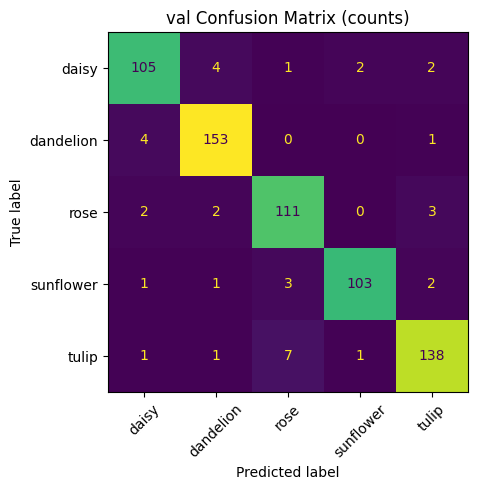

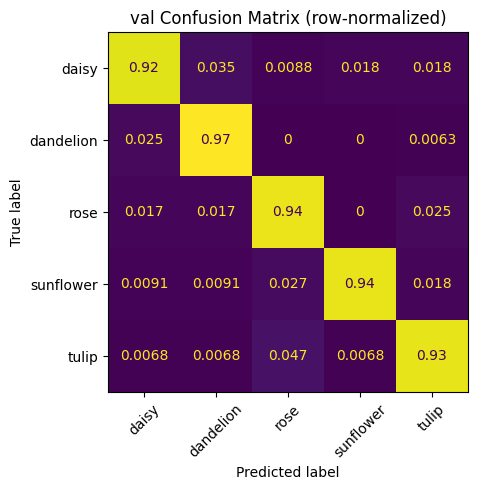


== VAL RESULTS ==
Accuracy:     0.9414
Macro-F1:     0.9404
Weighted-F1:  0.9414
Top-3 Acc:    0.9923
Per-class report saved to: /content/artifacts/classification_report_val.csv
Confusion matrices saved to:
  /content/artifacts/confusion_matrix_val_counts.png
  /content/artifacts/confusion_matrix_val_normalized.png


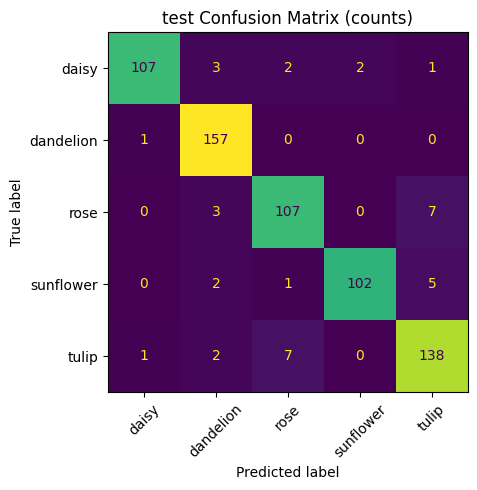

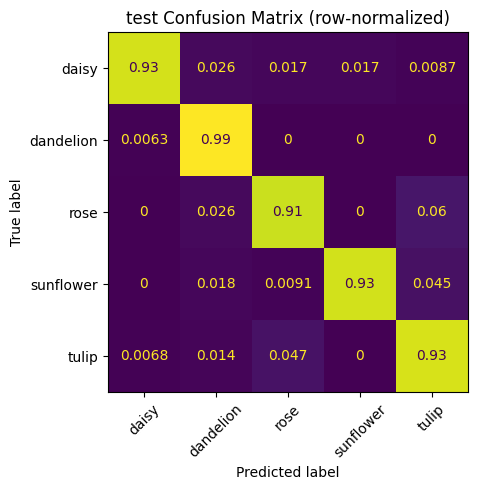


== TEST RESULTS ==
Accuracy:     0.9429
Macro-F1:     0.9425
Weighted-F1:  0.9429
Top-3 Acc:    0.9938
Per-class report saved to: /content/artifacts/classification_report_test.csv
Confusion matrices saved to:
  /content/artifacts/confusion_matrix_test_counts.png
  /content/artifacts/confusion_matrix_test_normalized.png


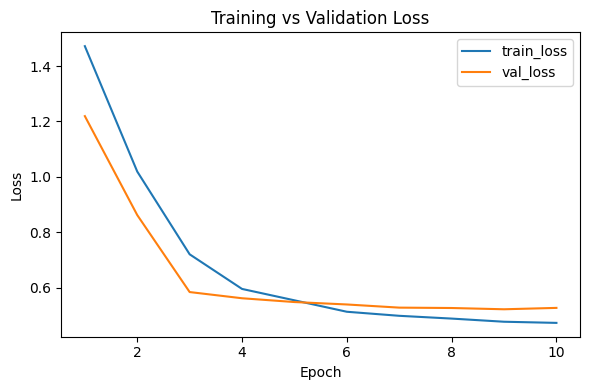

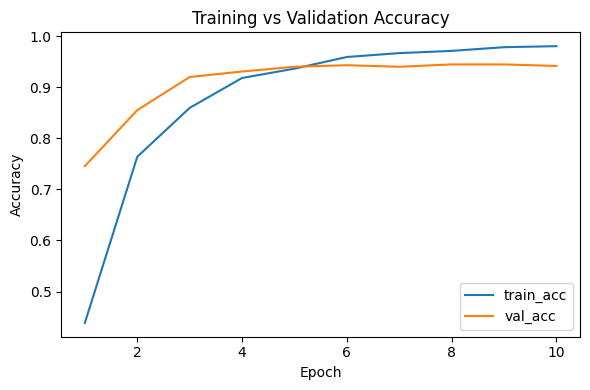

Saved curves:
  /content/artifacts/curve_loss.png
  /content/artifacts/curve_accuracy.png

Most-confused label pairs on VAL:
  tulip → rose: 7 samples
  daisy → dandelion: 4 samples
  dandelion → daisy: 4 samples
  rose → tulip: 3 samples
  sunflower → rose: 3 samples


In [10]:
# ==========================
# CRISP-DM: Evaluation & Testing
# Load best checkpoint, compute metrics, confusion matrices, and plot training curves
# ==========================
import json, math
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from torchvision import models, transforms
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score,
    accuracy_score, ConfusionMatrixDisplay, top_k_accuracy_score
)
import matplotlib.pyplot as plt
import pandas as pd

assert 'CFG' in globals(), "Missing CFG. Please run Chunk 1."
assert 'val_loader' in globals() and 'test_loader' in globals(), "Missing dataloaders. Please run Chunk 3."
ART = CFG.artifacts_dir
CKPT_PATH = ART / "best_model.pt"
HIST_PATH = ART / "train_history.json"
assert CKPT_PATH.exists(), f"Checkpoint not found at {CKPT_PATH}. Please run Chunk 4 (training)."

# --------------------------
# 1) Rebuild model skeleton (no pretrained download), then load weights
# --------------------------
def build_skeleton(model_name: str, num_classes: int) -> nn.Module:
    """Create architecture with random init; we'll load trained weights next."""
    if model_name == "efficientnet_b0":
        net = models.efficientnet_b0(weights=None)
        in_features = net.classifier[1].in_features
        net.classifier[1] = nn.Linear(in_features, num_classes)
    elif model_name == "mobilenet_v3_small":
        net = models.mobilenet_v3_small(weights=None)
        in_features = net.classifier[-1].in_features
        net.classifier[-1] = nn.Linear(in_features, num_classes)
    else:
        raise ValueError(f"Unsupported model_name: {model_name}")
    return net

ckpt = torch.load(CKPT_PATH, map_location=DEVICE)
model_name = ckpt.get("model_name", CFG.model_name)
class_names = ckpt.get("class_names")
num_classes = len(class_names)
image_size = ckpt.get("image_size", CFG.image_size)
norm_mean = ckpt.get("norm_mean", (0.485,0.456,0.406))
norm_std  = ckpt.get("norm_std",  (0.229,0.224,0.225))

model = build_skeleton(model_name, num_classes).to(DEVICE)
model.load_state_dict(ckpt["state_dict"], strict=True)
model.eval()

# --------------------------
# 2) Helper: run inference over a loader
# --------------------------
@torch.no_grad()
def predict_loader(model, loader, device=DEVICE):
    y_true, y_pred, y_scores = [], [], []
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        logits = model(xb)
        probs = torch.softmax(logits, dim=1)
        preds = probs.argmax(1)
        y_true.append(yb.cpu().numpy())
        y_pred.append(preds.cpu().numpy())
        y_scores.append(probs.cpu().numpy())
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    y_scores = np.concatenate(y_scores)
    return y_true, y_pred, y_scores

def eval_and_report(split_name, loader):
    y_true, y_pred, y_scores = predict_loader(model, loader, DEVICE)

    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    weighted_f1 = f1_score(y_true, y_pred, average="weighted")

    # Top-3 accuracy (robust to class confusions)
    try:
        top3 = top_k_accuracy_score(y_true, y_scores, k=min(3, y_scores.shape[1]))
    except Exception:
        top3 = None

    # Per-class report
    report_dict = classification_report(
        y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0
    )
    report_df = pd.DataFrame(report_dict).transpose()
    report_csv = ART / f"classification_report_{split_name}.csv"
    report_df.to_csv(report_csv, index=True)

    # Confusion matrices (raw and normalized)
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
    cm_norm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))), normalize="true")

    fig1, ax1 = plt.subplots(figsize=(6,5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(include_values=True, cmap=None, ax=ax1, xticks_rotation=45, colorbar=False)
    plt.title(f"{split_name} Confusion Matrix (counts)")
    plt.tight_layout()
    cm_counts_png = ART / f"confusion_matrix_{split_name}_counts.png"
    plt.savefig(cm_counts_png, dpi=160)
    plt.show()

    fig2, ax2 = plt.subplots(figsize=(6,5))
    disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=class_names)
    disp2.plot(include_values=True, cmap=None, ax=ax2, xticks_rotation=45, colorbar=False)
    plt.title(f"{split_name} Confusion Matrix (row-normalized)")
    plt.tight_layout()
    cm_norm_png = ART / f"confusion_matrix_{split_name}_normalized.png"
    plt.savefig(cm_norm_png, dpi=160)
    plt.show()

    # Save summary JSON
    summary = {
        "split": split_name,
        "accuracy": float(acc),
        "macro_f1": float(macro_f1),
        "weighted_f1": float(weighted_f1),
        "top3_accuracy": (float(top3) if top3 is not None else None),
        "num_samples": int(len(y_true)),
        "classes": class_names,
        "report_csv": str(report_csv),
        "confusion_counts_png": str(cm_counts_png),
        "confusion_norm_png": str(cm_norm_png),
    }
    with open(ART / f"eval_{split_name}.json", "w") as f:
        json.dump(summary, f, indent=2)

    # Print concise summary
    print(f"\n== {split_name.upper()} RESULTS ==")
    print(f"Accuracy:     {acc:.4f}")
    print(f"Macro-F1:     {macro_f1:.4f}")
    print(f"Weighted-F1:  {weighted_f1:.4f}")
    if top3 is not None:
        print(f"Top-3 Acc:    {top3:.4f}")
    print(f"Per-class report saved to: {report_csv}")
    print(f"Confusion matrices saved to:\n  {cm_counts_png}\n  {cm_norm_png}")

    return summary, (y_true, y_pred, y_scores)

val_summary, (y_true_val, y_pred_val, y_scores_val) = eval_and_report("val", val_loader)
test_summary, (y_true_test, y_pred_test, y_scores_test) = eval_and_report("test", test_loader)

# --------------------------
# 3) Plot training curves from history
# --------------------------
if HIST_PATH.exists():
    with open(HIST_PATH) as f:
        hist = json.load(f)
    # Convert to DataFrame for convenience
    hist_df = pd.DataFrame(hist)
    # Curves
    plt.figure(figsize=(6,4))
    plt.plot(hist_df["epoch"], hist_df["train_loss"], label="train_loss")
    plt.plot(hist_df["epoch"], hist_df["val_loss"], label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training vs Validation Loss")
    plt.legend(); plt.tight_layout()
    loss_png = ART / "curve_loss.png"
    plt.savefig(loss_png, dpi=160)
    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(hist_df["epoch"], hist_df["train_acc"], label="train_acc")
    plt.plot(hist_df["epoch"], hist_df["val_acc"], label="val_acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Training vs Validation Accuracy")
    plt.legend(); plt.tight_layout()
    acc_png = ART / "curve_accuracy.png"
    plt.savefig(acc_png, dpi=160)
    plt.show()

    print(f"Saved curves:\n  {loss_png}\n  {acc_png}")
else:
    print(f"No history file at {HIST_PATH}; skipping curves.")

# --------------------------
# 4) (Optional) Most-confused pairs helper (simple, fast)
# --------------------------
def most_confused_pairs(y_true, y_pred, class_names, top_k=5):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
    np.fill_diagonal(cm, 0)  # ignore correct predictions
    pairs = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm[i, j] > 0:
                pairs.append((class_names[i], class_names[j], int(cm[i, j])))
    pairs.sort(key=lambda x: x[2], reverse=True)
    return pairs[:top_k]

pairs = most_confused_pairs(y_true_val, y_pred_val, class_names, top_k=5)
if pairs:
    print("\nMost-confused label pairs on VAL:")
    for a, b, c in pairs:
        print(f"  {a} → {b}: {c} samples")


In [11]:
# ==========================
# CRISP-DM: Deployment & Inference
# Load best checkpoint; single/batch inference; optional TTA; export (TorchScript/ONNX)
# ==========================
from pathlib import Path
import json, math, random
from typing import List, Dict, Tuple
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torchvision import models, transforms

assert 'CFG' in globals(), "CFG not found. Run Chunk 1."
ART = CFG.artifacts_dir
CKPT_PATH = ART / "best_model.pt"
assert CKPT_PATH.exists(), f"Missing {CKPT_PATH}. Train the model first (Chunk 4)."

# --------- Load checkpoint metadata ---------
ckpt = torch.load(CKPT_PATH, map_location=DEVICE)
MODEL_NAME  = ckpt.get("model_name", CFG.model_name)
CLASS_NAMES = ckpt["class_names"]
NUM_CLASSES = len(CLASS_NAMES)
IMG_SIZE    = ckpt.get("image_size", CFG.image_size)
NORM_MEAN   = ckpt.get("norm_mean", (0.485, 0.456, 0.406))
NORM_STD    = ckpt.get("norm_std",  (0.229, 0.224, 0.225))

# Persist label mapping for external consumers
labels_txt = ART / "labels.txt"
with open(labels_txt, "w") as f:
    for cls in CLASS_NAMES:
        f.write(cls + "\n")
print(f"Saved label mapping to {labels_txt}")

# --------- Transforms for inference (match evaluation) ---------
def infer_transforms(image_size: int = IMG_SIZE):
    return transforms.Compose([
        transforms.Resize(int(image_size * 1.15)),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize(NORM_MEAN, NORM_STD),
    ])

TFM_INFER = infer_transforms(IMG_SIZE)

# --------- Build skeleton & load weights (no extra download) ---------
def build_skeleton(model_name: str, num_classes: int) -> nn.Module:
    if model_name == "efficientnet_b0":
        net = models.efficientnet_b0(weights=None)
        in_features = net.classifier[1].in_features
        net.classifier[1] = nn.Linear(in_features, num_classes)
    elif model_name == "mobilenet_v3_small":
        net = models.mobilenet_v3_small(weights=None)
        in_features = net.classifier[-1].in_features
        net.classifier[-1] = nn.Linear(in_features, num_classes)
    else:
        raise ValueError(f"Unsupported model_name: {model_name}")
    return net

MODEL = build_skeleton(MODEL_NAME, NUM_CLASSES).to(DEVICE)
MODEL.load_state_dict(ckpt["state_dict"], strict=True)
MODEL.eval()
print(f"Loaded model '{MODEL_NAME}' with {NUM_CLASSES} classes on device={DEVICE}.")

# --------- Helpers ---------
def _load_image(path: str) -> Image.Image:
    img = Image.open(path).convert("RGB")
    return img

@torch.no_grad()
def predict_tensor(t: torch.Tensor, model: nn.Module, topk: int = 3) -> Dict:
    """
    t: Tensor of shape [C,H,W] (single image, normalized).
    Returns dict with topk indices, labels, probs.
    """
    model.eval()
    xb = t.unsqueeze(0).to(DEVICE, non_blocking=True)  # [1, C, H, W]
    logits = model(xb)
    probs = torch.softmax(logits, dim=1).squeeze(0)    # [C]
    topk = min(topk, probs.shape[0])
    vals, idxs = torch.topk(probs, k=topk)
    idxs = idxs.cpu().tolist()
    vals = vals.cpu().tolist()
    return {
        "topk_indices": idxs,
        "topk_labels": [CLASS_NAMES[i] for i in idxs],
        "topk_probs": [float(p) for p in vals],
    }

@torch.no_grad()
def predict_image(path: str, model: nn.Module = MODEL, topk: int = 3, tta: bool = False) -> Dict:
    """
    Runs inference on a single image file. If tta=True, averages original + hflip.
    """
    img = _load_image(path)
    t = TFM_INFER(img)
    if not tta:
        res = predict_tensor(t, model, topk=topk)
        res["path"] = path
        return res
    else:
        # Simple TTA: original + horizontal flip (very cheap)
        t_flip = transforms.functional.hflip(img)
        t1 = TFM_INFER(img).unsqueeze(0)
        t2 = TFM_INFER(t_flip).unsqueeze(0)
        xb = torch.cat([t1, t2], dim=0).to(DEVICE, non_blocking=True)  # [2, C, H, W]
        logits = model(xb).mean(dim=0, keepdim=True)                   # average logits
        probs = torch.softmax(logits, dim=1).squeeze(0)
        k = min(topk, probs.shape[0])
        vals, idxs = torch.topk(probs, k=k)
        idxs = idxs.cpu().tolist(); vals = vals.cpu().tolist()
        return {
            "path": path,
            "topk_indices": idxs,
            "topk_labels": [CLASS_NAMES[i] for i in idxs],
            "topk_probs": [float(p) for p in vals],
            "tta": "hflip",
        }

@torch.no_grad()
def predict_batch(paths: List[str], model: nn.Module = MODEL, topk: int = 3, tta: bool = False) -> List[Dict]:
    results = []
    for p in paths:
        try:
            results.append(predict_image(p, model, topk=topk, tta=tta))
        except Exception as e:
            results.append({"path": p, "error": str(e)})
    return results

def pretty_print_prediction(pred: Dict):
    if "error" in pred:
        print(f"[ERROR] {pred['path']}: {pred['error']}")
        return
    print(f"\nFile: {pred['path']}")
    for i, (lbl, prob) in enumerate(zip(pred["topk_labels"], pred["topk_probs"]), 1):
        print(f"  {i}. {lbl:>12s}  p={prob:.3f}")

# --------- Quick demo on a few test images (optional) ---------
test_csv = ART / "test.csv"
if test_csv.exists():
    import pandas as pd
    test_df = pd.read_csv(test_csv)
    demo_paths = test_df.sample(n=min(5, len(test_df)), random_state=123)["path"].tolist()
    print("\nDemo predictions on a few test images:")
    preds = predict_batch(demo_paths, MODEL, topk=3, tta=False)
    for p in preds:
        pretty_print_prediction(p)
else:
    print("No test.csv found for demo. Skipping.")

# --------- Export: TorchScript (portable .pt) ---------
def export_torchscript(model: nn.Module, save_path: Path, image_size: int = IMG_SIZE):
    model = model.to("cpu").eval()  # portable
    dummy = torch.randn(1, 3, image_size, image_size)
    with torch.no_grad():
        traced = torch.jit.trace(model, dummy)
    torch.jit.save(traced, save_path)
    print(f"TorchScript saved to: {save_path}")

# Uncomment to export TorchScript
# export_torchscript(MODEL, ART / "model_torchscript.pt", image_size=IMG_SIZE)

# --------- Export: ONNX (optional) ---------
def export_onnx(model: nn.Module, save_path: Path, image_size: int = IMG_SIZE):
    try:
        import onnx  # noqa: F401
    except ImportError:
        print("onnx not installed; run `pip install onnx onnxruntime` to enable ONNX export.")
        return
    model = model.to("cpu").eval()
    dummy = torch.randn(1, 3, image_size, image_size)
    torch.onnx.export(
        model, dummy, str(save_path),
        input_names=["input"], output_names=["logits"],
        opset_version=12, dynamic_axes={"input": {0: "batch"}, "logits": {0: "batch"}}
    )
    print(f"ONNX saved to: {save_path}")

# Uncomment to export ONNX
# export_onnx(MODEL, ART / "model.onnx", image_size=IMG_SIZE)


Saved label mapping to /content/artifacts/labels.txt
Loaded model 'efficientnet_b0' with 5 classes on device=cpu.

Demo predictions on a few test images:

File: /kaggle/input/flowers-recognition/flowers/daisy/2607132536_d95198e619_n.jpg
  1.        tulip  p=0.545
  2.    dandelion  p=0.238
  3.        daisy  p=0.135

File: /kaggle/input/flowers-recognition/flowers/tulip/3511104954_54eace015c_n.jpg
  1.        tulip  p=0.945
  2.    sunflower  p=0.021
  3.    dandelion  p=0.015

File: /kaggle/input/flowers-recognition/flowers/daisy/4544110929_a7de65d65f_n.jpg
  1.        daisy  p=0.766
  2.    dandelion  p=0.148
  3.        tulip  p=0.039

File: /kaggle/input/flowers-recognition/flowers/tulip/3454461550_64d6e726bf_m.jpg
  1.        tulip  p=0.703
  2.        daisy  p=0.106
  3.         rose  p=0.081

File: /kaggle/input/flowers-recognition/flowers/tulip/14069914777_b10856aaf7_n.jpg
  1.        tulip  p=0.845
  2.    sunflower  p=0.069
  3.    dandelion  p=0.037
